In [1]:
# fit stochastic model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Other fitting packages we don't need here
# import time
# from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
# from scipy import stats
# import pymc as pm
# from scipy.optimize import curve_fit

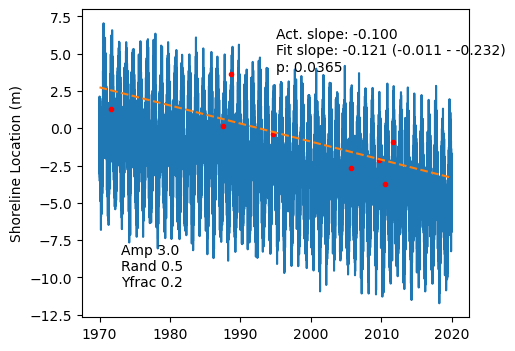

In [2]:
# put in a seed to get repeatable results...remove to vary results
np.random.seed(42) 

# daily time series
tstart=1970.
tend=2020.
dt = 1./365 
t = np.arange(tstart, tend , dt)

# wavenumber of annual cycle
T = 1.
omega = 2.*np.pi / T

# amplitude of annual cycle (m)
aa = 3.

# random variation: 10% of annual amplitude
mu = 0.
rfrac = .5
sigma = rfrac*aa
r = np.random.normal(loc=mu, scale=sigma, size=len(t))

# trend (m/y)
tr = -.1 

# shoreline location = trend + annual fluctuation + random variation
# (the +pi/2 term shifts the wider beach to summer months, kind of)
sloc = tr*(t-tstart) + aa*np.cos( (omega * t)+np.pi/2. ) + r

# generate random survey dates, constrained to approx. mid-year
survey_year = np.sort( np.random.randint(low=tstart, high=tend + 1, size=8) )
# yfrac is the fraction of year the sample can occur...small number == sampling at same time every year
yfrac=.2
# st_low is the begining of the sample time
st_low = .5
# st_hi is the end of the sample time
st_hi = st_low+yfrac
survey_yfrac = np.random.uniform(low=st_low, high=st_hi, size=8)
survey_t = survey_year + survey_yfrac

# Find the indices of t that are closest to survey_t
closest_idx = np.searchsorted(t, survey_t)

# Get the times and corresponding shoreline locations for those random times
ts = t[closest_idx]
ssloc = sloc[closest_idx]

# fit the survey points
x = ts
y = ssloc
# Set up for statsmodels OLS
# need a column of ones to fit intercept
X = np.column_stack( (x, np.ones_like(x) ))

# Ordinary least-squares fit
OLSfit = sm.OLS(y, X).fit()
OLS_slope, OLS_intercept = OLSfit.params
OLS_pvalues = OLSfit.pvalues        
# Compute the 95% confidence interval for all parameters
OLSconf_int = OLSfit.conf_int(alpha=0.05)  # Default is 95% CI
slope_lo = OLSconf_int[0,0]
slope_hi = OLSconf_int[0,1]
# Extract the slope's confidence interval
OLSslope_CI = OLSconf_int[0]  # First row corresponds to the slope

t_hat = np.arange(tstart, tend+10 ,10)
sloc_hat = OLS_intercept + OLS_slope*t_hat

txt2 = 'Amp {}\nRand {}\nYfrac {}'.format( aa, rfrac, yfrac)
txt = 'Act. slope: {:.3f}\nFit slope: {:.3f} ({:.3f} - {:.3f})\np: {:.4f}'.format(tr, OLS_slope, slope_hi, slope_lo, OLS_pvalues[0])

fig, ax = plt.subplots(1,1, figsize = (5,4))
plt.plot(t, sloc)
plt.plot(ts, ssloc, '.r')
plt.plot(t_hat, sloc_hat, '--', c='tab:orange')
plt.ylabel('Shoreline Location (m)')
ax.text(.5, .8, txt, transform=ax.transAxes)
_ = ax.text(.1, .1, txt2, transform=ax.transAxes)